In [1]:
import matplotlib
import pandas as pd
import numpy as np
import scipy.stats as si
import sympy as sy
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import norm
pd.options.display.max_columns = None
#os.chdir('C:/Users/regru/Desktop/Springboard/naive_bayes/naive_bayes')

In [54]:
critics = pd.read_csv('critics.csv')

In [55]:
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
0,Owen Gleiberman,fresh,114709,Entertainment Weekly,NaN,2011-09-07,9559,Toy story
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story


In [56]:
critics.isna().sum()

critic          3891
fresh              0
imdb               0
publication        0
quote          12070
review_date        0
rtid               0
title              0
dtype: int64

In [57]:
critics['fresh'].unique()

array(['fresh', 'rotten', 'none'], dtype=object)

In [60]:
df = critics.dropna()
df = df[df['fresh'] != 'none']

In [61]:
df.isna().sum()

critic         0
fresh          0
imdb           0
publication    0
quote          0
review_date    0
rtid           0
title          0
dtype: int64

In [62]:
df['fresh'].unique()

array(['fresh', 'rotten'], dtype=object)

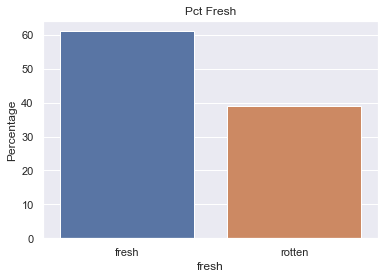

In [63]:
import warnings
warnings.filterwarnings("ignore")
sns.set()
sns.barplot(x='fresh',y='fresh',data=df, estimator=lambda x: len(x) / len(df) * 100,orient="v").set(ylabel='Percentage',title='Pct Fresh')
plt.show()

In [64]:
import re
import nltk
from nltk.corpus import stopwords
def remove_stopwords(text):
    letters_only = re.sub("[^a-zA-Z]", " ",text) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words )) 

In [65]:
# create labels to predict fresh review
df['review'] = df['fresh'].apply(lambda x: 0 if x == 'rotten' else 1)

In [67]:
warnings.filterwarnings("ignore")
from sklearn.cross_validation import train_test_split
# remove characters and stop words from each review
df['clean_review'] = df['quote'].apply(lambda x: remove_stopwords(x))
features = df['clean_review'].values
label = df['review'].values
xtrain, xtest, ytrain, ytest = train_test_split(features,label,test_size=0.2,random_state=84)

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer
# setup tf-idf count vectorizer
tfidf_vec_train=TfidfVectorizer(lowercase=True)
# fit vectorizer
train_tfidf_vectors = tfidf_vec_train.fit_transform(xtrain)

In [69]:
# get the first vector out (for the first document)
first_vector_tfidfvectorizer = train_tfidf_vectors[0]
# place tf-idf values in a pandas data frame
tf_idf_df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vec_train.get_feature_names(), columns=["tfidf"])
tf_idf_df.sort_values(by=["tfidf"],ascending=False)[0:10]

,tfidf
remarkable,0.715952
achievement,0.698150
aaron,0.000000
preens,0.000000
prefontaine,0.000000
prefers,0.000000
preferably,0.000000
prefer,0.000000
prefabricated,0.000000
prefab,0.000000


In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [71]:
# Function to evaluate multiple models
from sklearn import pipeline,ensemble,preprocessing,feature_extraction,cross_validation,metrics
def nlp_pipeline(xtrain,ytrain,xtest,ytest,transformer,classifiers_list):
    for classifier in classifiers_list:
        clf = pipeline.Pipeline([('transformer', transformer),('classifier', classifier)])
        clf.fit(xtrain,ytrain)
        pred = clf.predict(xtest)
        #accuracy = accuracy_score(pred,ytest)
        auc = roc_auc_score(ytest, clf.predict_proba(xtest)[:,1])
        print('AUC Score for '+classifier.__class__.__name__+' is '+str(auc))

In [103]:
tranf = feature_extraction.text.TfidfVectorizer(use_idf=True)
Classifiers = [
    LogisticRegression(C=0.001,solver='liblinear',max_iter=200),
    SVC(kernel="rbf", C=0.025, probability=True),
    RandomForestClassifier(n_estimators=200),
    MultinomialNB()]

In [104]:
nlp_pipeline(xtrain,ytrain,xtest,ytest,tranf,Classifiers)

AUC Score for LogisticRegression is 0.7667711432214194
AUC Score for SVC is 0.7618079434377778
AUC Score for RandomForestClassifier is 0.7767113066491519
AUC Score for MultinomialNB is 0.8371112313101262


In [114]:
from sklearn.grid_search import GridSearchCV
# setup tf-idf count vectorizer
tfidf_vec_train=TfidfVectorizer(lowercase=True)
# fit vectorizer
train_tfidf_vectors = tfidf_vec_train.fit_transform(xtrain)
nb = MultinomialNB() 
param_grid = {'alpha': [.0001,.001,.01,.1,.2,.3,.4,.5,2,5]}
CV_rfc = GridSearchCV(estimator=nb, param_grid=param_grid, scoring='roc_auc', cv= 5)
CV_rfc.fit(train_tfidf_vectors, ytrain)
CV_rfc.best_params_

{'alpha': 0.5}

In [115]:
CV_rfc.grid_scores_

[mean: 0.72965, std: 0.00361, params: {'alpha': 0.0001},
 mean: 0.74618, std: 0.00343, params: {'alpha': 0.001},
 mean: 0.77601, std: 0.00297, params: {'alpha': 0.01},
 mean: 0.81901, std: 0.00254, params: {'alpha': 0.1},
 mean: 0.83079, std: 0.00258, params: {'alpha': 0.2},
 mean: 0.83636, std: 0.00268, params: {'alpha': 0.3},
 mean: 0.83953, std: 0.00291, params: {'alpha': 0.4},
 mean: 0.84139, std: 0.00313, params: {'alpha': 0.5},
 mean: 0.83980, std: 0.00514, params: {'alpha': 2},
 mean: 0.82552, std: 0.00618, params: {'alpha': 5}]

In [192]:
# Use best performing model
from sklearn import pipeline,ensemble,preprocessing,feature_extraction,cross_validation,metrics
nb_clf = pipeline.Pipeline([
        ('tfidf_vectorizer', feature_extraction.text.TfidfVectorizer(min_df=.001,use_idf=True)),
        ('NB_Classifier', MultinomialNB(alpha=0.5))])

In [193]:
# Fit model
nb_clf.fit(xtrain,ytrain)

Pipeline(memory=None,
     steps=[('tfidf_vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.001,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smo...   vocabulary=None)), ('NB_Classifier', MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True))])

In [194]:
preds=nb_clf.predict(xtest)
# confusion matrix for randomforest
pd.crosstab(ytest, preds, rownames=['Actual'], colnames=['Predicted'], margins=True,normalize='all')

Predicted,0,1,All
Actual,,,
0,0.189235,0.198037,0.387271
1,0.061273,0.551456,0.612729
All,0.250508,0.749492,1.000000


In [195]:
pred_train = nb_clf.predict(xtrain)
print("Accuracy on training data: {:2f}".format(accuracy_score(ytrain, pred_train)))
print("Accuracy on test data: {:2f}".format(accuracy_score(ytest, preds)))

Accuracy on training data: 0.794177
Accuracy on test data: 0.740691
